In [1]:
#import pakackages
import pandas as pd 
import numpy as np
import seaborn as sns
import sklearn
from sklearn.feature_selection import mutual_info_classif, SelectKBest,SelectPercentile
from statsmodels.stats.weightstats import ztest as ztest
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#read in data
FILE_LOCATION = 'lease_renewal.csv'
input_df = pd.read_csv(FILE_LOCATION)

## Chart Functions and Feature Selection

In [3]:
#distribution chart for target variable vs binary variable

def distribution_plot(input_df,input_column_range):
    for column in input_column_range:    
        occupation_counts = (input_df.groupby([column])['Renewed']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('Renewed'))
        g = sns.catplot(x=column,y='percentage',hue='Renewed',kind='bar',data=occupation_counts).set(title=f'{column} distro')    
        g.ax.set_ylim(0,100)
        for p in g.ax.patches:
            txt = str(p.get_height().round(2)) + '%'
            txt_x = p.get_x() 
            txt_y = p.get_height()
            g.ax.text(txt_x,txt_y,txt)
        plt.show()

# seaborn correltion chart
def gen_heat_map(corr):
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );
#mutual info function for list of columns    
def mutual_info(X,y,select_k=10):
    if select_k >= 1:
        sel_ = SelectKBest(mutual_info_classif, k=select_k).fit(X,y)
        col = X.columns[sel_.get_support()]
    elif 0 < select_k < 1:
        sel_ = SelectPercentile(mutual_info_classif, percentile=select_k*100).fit(X,y)
        col = X.columns[sel_.get_support()]   
    else:
        raise ValueError("select_k must be a positive number")
    return col
#information value and weight of evidence
def iv_woe(df,feature_list,target):
    for feature in feature_list:
        d0=pd.DataFrame({'x': df[feature], 'y': df[target]})
        d=d0.groupby('x', as_index=False).agg({'y':['count','sum']})
        d.columns=['Cutoff', 'N', 'Events']
        d['% of Events']=np.maximum(d['Events'],0.5)/d['Events'].sum()
        d['Non-Events']=d['N'] - d['Events']
        d['% of Non-Events']=np.maximum(d['Non-Events'],0.5)/d['Non-Events'].sum()
        d['WoE']=np.log(d['% of Events']/d['% of Non-Events'])
        d['IV']= d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        print(d[['Cutoff','% of Events','% of Non-Events','WoE','IV']])
        print(f"Information value of {feature} is {round(d['IV'].sum(),4)}")

### EDA 
#### Perform data analysis and provide key stats and histogram

In [4]:
input_df.columns # list out all columns that is easier for copy/paste

Index(['lease_id', 'no_rent_change', 'rent_change_10', 'rent_change_20',
       'lease_length_2', 'lease_length_3', 'lease_length_1',
       'age_range_under_24', 'age_range_24_29', 'age_range_30_39',
       'age_range_40_49', 'age_range_50_59', 'age_range_60',
       'NoFinesViolations', 'PositiveSurvey', 'LatePayments', 'HOA_mandatory',
       'Renewed'],
      dtype='object')

In [5]:
#split all range grounds together into lists
age_range = ['age_range_under_24', 'age_range_24_29', 'age_range_30_39',
       'age_range_40_49', 'age_range_50_59', 'age_range_60',]
lease_range = ['lease_length_2', 'lease_length_3', 'lease_length_1',]
rent_change = ['no_rent_change', 'rent_change_10', 'rent_change_20']

Add variable ranges for age, lease and rent change for further analysis

In [6]:
shape=input_df.shape
print(f"My data set has {shape[0]} rows and columns {shape[1]}")

My data set has 79850 rows and columns 18


In [7]:
input_description=input_df.describe()## double confirm that all variables are binary
input_description

,no_rent_change,rent_change_10,rent_change_20,lease_length_2,lease_length_3,lease_length_1,age_range_under_24,age_range_24_29,age_range_30_39,age_range_40_49,age_range_50_59,age_range_60,NoFinesViolations,PositiveSurvey,LatePayments,HOA_mandatory,Renewed
count,79850.000000,79850.000000,79850.000000,79850.000000,79850.000000,79850.000000,79850.000000,79850.000000,79850.000000,79850.000000,79850.000000,79850.000000,79850.000000,79850.000000,79850.000000,79850.000000,79850.000000
mean,0.221428,0.023532,0.581866,0.245172,0.057495,0.524859,0.038309,0.091947,0.149192,0.108604,0.059136,0.020977,0.139249,0.269142,0.566399,0.164133,0.195892
std,0.415210,0.151586,0.493256,0.430192,0.232788,0.499385,0.191943,0.288953,0.356280,0.311143,0.235880,0.143308,0.346208,0.443517,0.495575,0.370398,0.396888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Distribution of feature bins based of mean

<AxesSubplot:>

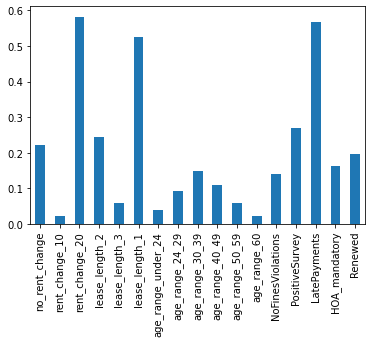

In [8]:
mean_row=input_description.iloc[1]
mean_row.plot(kind='bar')

Sample size is high on rent change 20, late payments, and first time leases with demographics of 30-49 
Not alot of renewals are happening within the data set. I would have to generate some sample distribution plots to take a look at renewal y/n

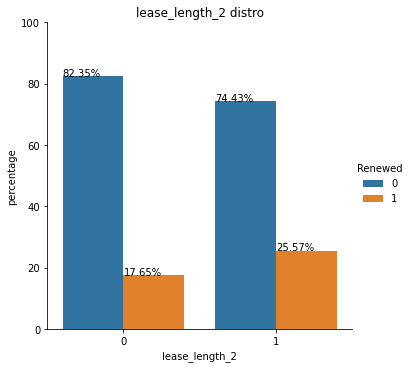

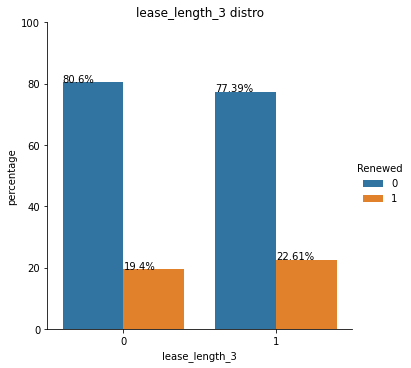

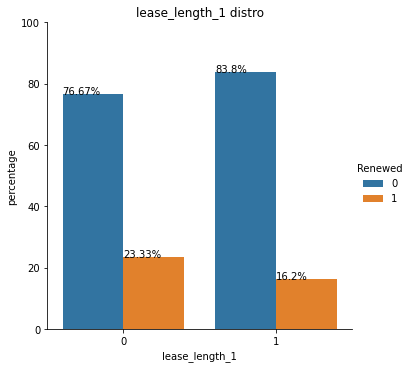

In [9]:
distribution_plot(input_df,lease_range)

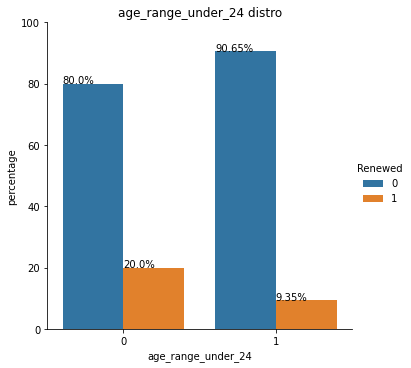

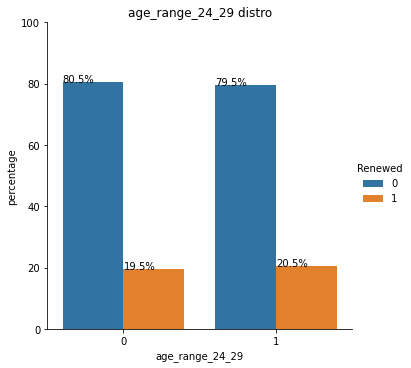

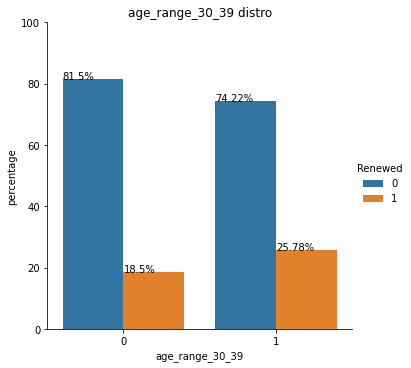

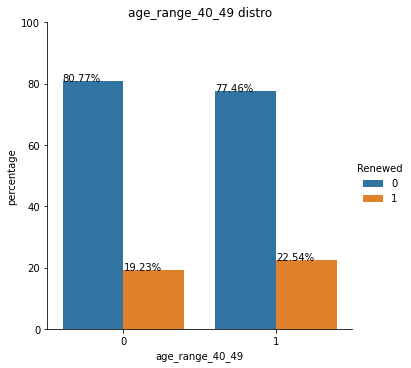

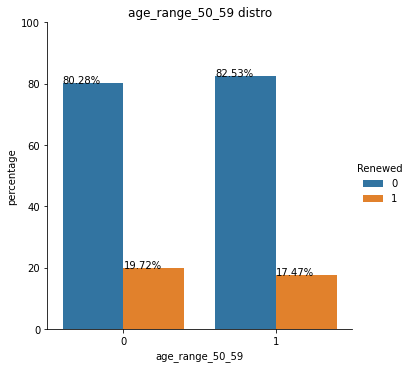

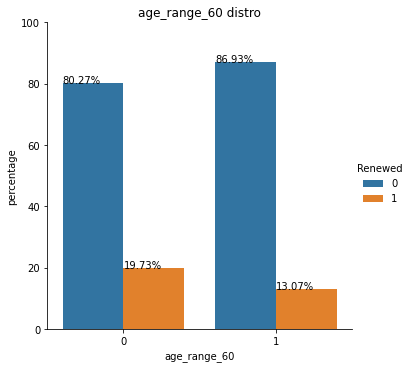

In [10]:
distribution_plot(input_df,age_range)

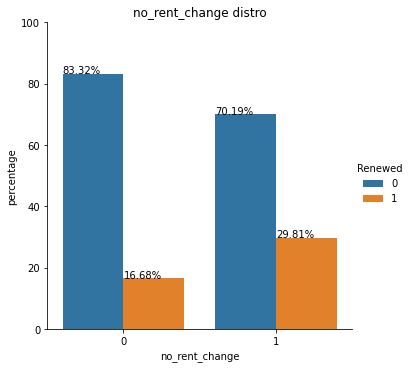

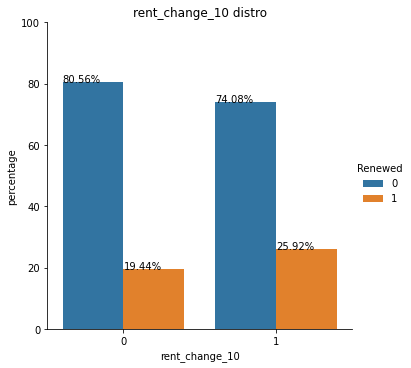

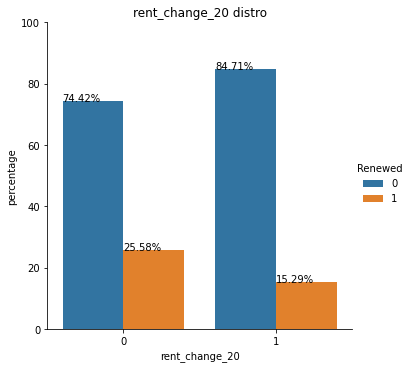

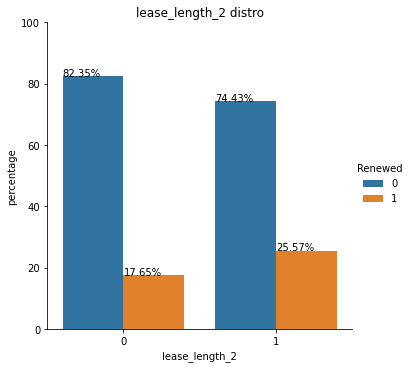

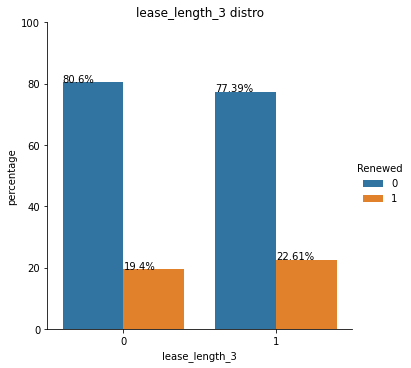

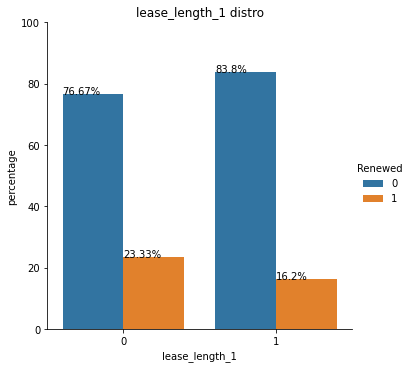

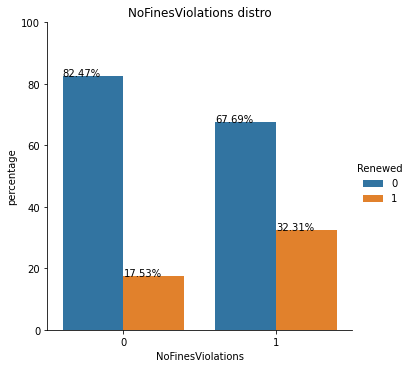

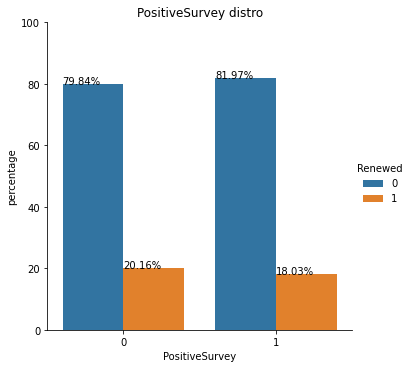

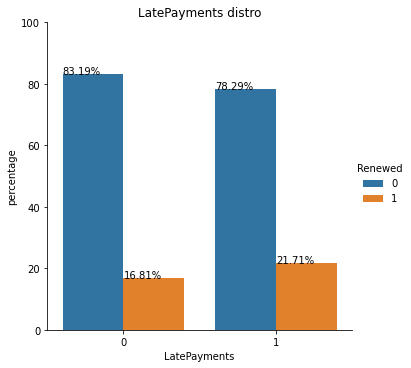

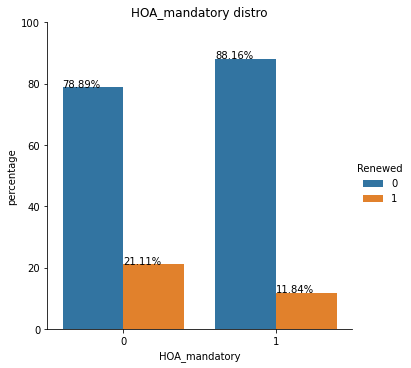

In [11]:
feature_of_interest =['no_rent_change', 'rent_change_10', 'rent_change_20',
       'lease_length_2', 'lease_length_3', 'lease_length_1',
       'NoFinesViolations','PositiveSurvey','LatePayments','HOA_mandatory']
distribution_plot(input_df,feature_of_interest)

A lot of information within distribution could be condensed down to a correlation chart to determine some promoters/detractors for renewal

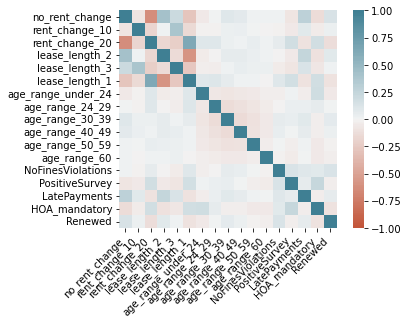

In [12]:
corr=input_df.corr()
corr=input_df.corr() # total heat map analysis
gen_heat_map(corr)

Based on the heat map we would focus on the top left corner, so we can zoom in to that section

In [13]:
feature_of_interest =['no_rent_change', 'rent_change_10', 'rent_change_20',
       'lease_length_2', 'lease_length_3', 'lease_length_1',
       'Renewed','NoFinesViolations','PositiveSurvey','LatePayments','HOA_mandatory']
corr_feature_of_interest=input_df[feature_of_interest].corr()

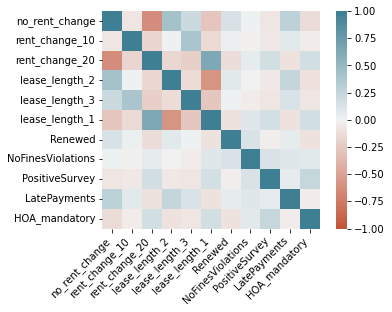

In [14]:
gen_heat_map(corr_feature_of_interest)

In [15]:
corr_feature_of_interest

,no_rent_change,rent_change_10,rent_change_20,lease_length_2,lease_length_3,lease_length_1,Renewed,NoFinesViolations,PositiveSurvey,LatePayments,HOA_mandatory
no_rent_change,1.000000,-0.082787,-0.629101,0.422300,0.210864,-0.286352,0.137282,0.016810,-0.083152,0.285416,-0.135749
rent_change_10,-0.082787,1.000000,-0.183126,0.021955,0.398191,-0.153562,0.024754,-0.021393,-0.051733,0.080144,-0.040463
rent_change_20,-0.629101,-0.183126,1.000000,-0.170224,-0.219047,0.635068,-0.127915,0.061253,0.173120,-0.086996,0.178707
lease_length_2,0.422300,0.021955,-0.170224,1.000000,-0.140762,-0.598993,0.085821,-0.006649,-0.048769,0.247932,-0.106515
lease_length_3,0.210864,0.398191,-0.219047,-0.140762,1.000000,-0.259588,0.018795,-0.045420,-0.082197,0.127953,-0.075460
lease_length_1,-0.286352,-0.153562,0.635068,-0.598993,-0.259588,1.000000,-0.089716,0.091784,0.164840,-0.097808,0.176184
Renewed,0.137282,0.024754,-0.127915,0.085821,0.018795,-0.089716,1.000000,0.128865,-0.023828,0.061214,-0.086500
NoFinesViolations,0.016810,-0.021393,0.061253,-0.006649,-0.045420,0.091784,0.128865,1.000000,0.121233,0.090746,0.078814
PositiveSurvey,-0.083152,-0.051733,0.173120,-0.048769,-0.082197,0.164840,-0.023828,0.121233,1.000000,0.059173,0.231419
LatePayments,0.285416,0.080144,-0.086996,0.247932,0.127953,-0.097808,0.061214,0.090746,0.059173,1.000000,-0.033310


# Summary of distribution, initial analysis 

Some observations to take note: 
1) people with rental_lease 1 - correlate with rental change 20% with upcoming rental change
2) survival rate of first years might go down because of rent charge - how do we keep people renewing while we charge them higher?

## Based on corr heat map - we can see that longer duration (lease_length) and lower rent change can possibly lead to higher renewals 

a) Possible promoters: lease_length 2-3, low rent change

b) Possible detractors: high rent change, Hoa mandatory neighborhoods

## Tenure and rent changes proves to be important

In [16]:
## feature of importance focus on customer history of duration of lease 3-2 -> 
# more profitable to renew vs signing another tenant?
## no rental change is an increased correlation of lease 3 and 2 

In [17]:
#Cleaner data frame for correlation analysis
corrmat = input_df.corr()
corrmat = corrmat.unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat < 1] # remove the digonal
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']

Clean table for analysis between positive/negative corr

In [18]:
corrmat[corrmat['feature1']=='Renewed']

,feature1,feature2,corr
24,Renewed,no_rent_change,0.137282
26,Renewed,NoFinesViolations,0.128865
46,Renewed,lease_length_2,0.085821
57,Renewed,age_range_30_39,0.065303
60,Renewed,LatePayments,0.061214
98,Renewed,age_range_40_49,0.025985
103,Renewed,rent_change_10,0.024754
110,Renewed,lease_length_3,0.018795
132,Renewed,age_range_24_29,0.007290
155,Renewed,age_range_50_59,-0.013378


### Splitting data into different groups

In [19]:
y_renewed=input_df[input_df.Renewed == 1]
n_renewed=input_df[input_df.Renewed == 0]

# Ztest on top 3 promoters

Testing if no_rent_change/ fines violations/ lease_length_2 has a p-value less than .05 to test hypothese

Null: There is no significant changes in renewal rates when they recieve a rent change

Alternative: There is a positive change in renewal rates when they receive no rent change as      opposed to being charged more for rent

In [20]:
ztest(y_renewed.no_rent_change,n_renewed.no_rent_change, value=0)

(39.1631942171942, 0.0)

Null: There is no significant changes in renewal rates when they recieve a FinesViolations

Alternative: There is a positive change in renewal rates when they receive no fine violations as  opposed to being fined

In [21]:
ztest(y_renewed.NoFinesViolations,n_renewed.NoFinesViolations, value=0)

(36.72010160302327, 3.4896994369854393e-295)

Null: There is no significant changes in renewal rates when they have a longer tenure in rent history

Alternative: There is a positive change in renewal rates when they have a longer tenure in rent history as opposed to staying only for one year

In [22]:
ztest(y_renewed.lease_length_2,n_renewed.lease_length_2, value=0)

(24.340471234388396, 7.313811943954183e-131)

All three ztest on the top 3 corr promoters suggest we have sufficient evidence to reject the null hypothesis. First element in the tuple suggest a positive change and second element is the P value < 0.05

# Ztest on top 3 detractors

Null: There is no significant changes in renewal rates when they recieve a rent change

Alternative: There is a negative change in renewal rates when they receive rent change as      opposed to not being charged for rent

In [23]:
ztest(y_renewed.rent_change_20,n_renewed.rent_change_20, value=0)

(-36.44486225044318, 8.297269755859786e-291)

Null: There is no significant changes in renewal rates when they have a shorter tenure in rent history

Alternative: There is a negative change in renewal rates when they have a shorter tenure in rent history as opposed to staying longer for more than one year

In [24]:
ztest(y_renewed.lease_length_1,n_renewed.lease_length_1, value=0)

(-25.45393375263121, 6.385931540882465e-143)

Null: There is no significant changes in renewal rates when you have HOA neighborhood

Alternative: There is a negative change in renewal rates when they have a HOA neigborhood opposed to staying in a non-HOA neighborhood

In [25]:
ztest(y_renewed.HOA_mandatory,n_renewed.HOA_mandatory, value=0)

(-24.534535510693892, 6.325401262234295e-133)

All three ztest on the top 3 detractors suggest we have sufficient evidence to reject the null hypothesis. First element in the tuple suggest a negative change and second element is the P value < 0.05

# Mutual Information

In [26]:
label='Renewed'
feature_list=[
 'no_rent_change',
 'rent_change_10',
 'rent_change_20',
 'lease_length_2',
 'lease_length_3',
 'lease_length_1',
 'age_range_under_24',
 'age_range_24_29',
 'age_range_30_39',
 'age_range_40_49',
 'age_range_50_59',
 'age_range_60',
 'NoFinesViolations',
 'PositiveSurvey',
 'LatePayments',
 'HOA_mandatory']
feature_df = input_df[feature_list]
label_df=input_df[label]

In [27]:
mutual_info(X=feature_df , y=label_df,)

Index(['no_rent_change', 'rent_change_20', 'lease_length_2', 'lease_length_1',
       'age_range_under_24', 'age_range_30_39', 'age_range_60',
       'NoFinesViolations', 'LatePayments', 'HOA_mandatory'],
      dtype='object')

Mutual information is beneficial for classification problems and also it verifies that rent change and lease tenure has an impact on feature selection

## Weight of Evidence and Information value - chart

In [28]:
iv_woe(df=input_df,feature_list=feature_list,target=label)

   Cutoff  % of Events  % of Non-Events       WoE        IV
0       0     0.663087         0.806706 -0.196054  0.028157
1       1     0.336913         0.193294  0.555615  0.079797
Information value of no_rent_change is 0.108
   Cutoff  % of Events  % of Non-Events       WoE        IV
0       0     0.968866          0.97832 -0.009711  0.000092
1       1     0.031134          0.02168  0.361935  0.003422
Information value of rent_change_10 is 0.0035
   Cutoff  % of Events  % of Non-Events       WoE        IV
0       0     0.545966         0.386992  0.344152  0.054711
1       1     0.454034         0.613008 -0.300205  0.047725
Information value of rent_change_20 is 0.1024
   Cutoff  % of Events  % of Non-Events       WoE        IV
0       0     0.680028          0.77305 -0.128210  0.011926
1       1     0.319972          0.22695  0.343504  0.031953
Information value of lease_length_2 is 0.0439
   Cutoff  % of Events  % of Non-Events       WoE        IV
0       0      0.93364         0.9446

The total IV information tell us that rental change brings out the most predictive power when it comes to renewal rates. As previous test shows rental change has the highest predictive power

## Exec Summary 
Based on the data between the distribution, correlation chart and zpop test - we can determine what are top promoters and detractors’ features effect on a potential model. Additionally Mutual info and WoE/IV test gives us the same data story as well. Rent change and tenure of stay effects renewal rates

Business Action Item :

    1) Decrease churn rate in 1st year rentals to help first rentals achieve tenure. 

    2) Find additional ways to reduce rent change across the board to promote renewal rates.

    4) Focus demographics on age ranges 30-49 as they are more likely to renew vs younger/senior population.

    5) Offer fine violation forgivness or some sort of credit application back into the account. 

    3) Analyze why HOA neighborhoods are less appealing for renewal rates? Is it the restrictive nature of HOA or lack of individuality of certain areas?

Additional comments:

More data could be beneficial to paint a better picture such as:

    1)Location based data so we can pinpoint where more renewals are coming from
    2)Income information about tenants 
    3)Education information about tenants (generate entire tenant feature dimension)